
<br>
<center>
<font size='7' style="color:#0D47A1">  <b>Regression Models For <br><br> Solubility Prediction</b> </font>
</center>

<hr style= "height:3px;">
<br>


<hr style= "height:1px;">
<font size='6' style="color:#000000">  <b>Content</b> </font>
<a name="content"></a>
<br>
<br>

1. [Abstract](#abstract) 
<br>

2. [Setup](#setup)
<br>

3. [Loading Data](#loading)
<br>

4. [Explore the Data](#exploration)
<br>

5. [Data Cleaning](#cleaning)
<br>

6. [Feature Selection](#features)
<br>

7. [Results & Discussion](#results)
<br>

8. [Perspectives](#perspectives)
<br>

9. [References](#references)
<br>

<hr style= "height:1px;">

<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>1. Abstract</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

<font size='4'>

In this Notebook we studied 3 different strategies for the training of various machine learning models. After comparing and choosing the best training strategy we proceed to evaluate the models with an additional cross validation step. The model performance are reported in with two generic metrics and choose or definition for a better metric for the problem at hand is a work in progress. 

</font> 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Purpose</b></font>

<br>
<font size='4'>
    
Obtain the best training strategy for generic ML Model.

</font> 


<br>
<br>


<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Goals</b></font>


 - Find the best training strategy.
 - Define custome metrics for evaluation.
 - Compare several ML models.
 - Obtain statistics of model training with cross validation.
 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Methodology/Plan</b></font>

1. Strategy 1.
 - No feature or targe transformation.
2. Strategy 2.
 - Feature transformation.
 - Target transformation.
3. Strategy 3.
 - Feature transformation.
 - Target transformation.
4. Benchmark.
 - Include cross validation in the training process.
 



<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>2. Setup</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

The following imports are divided by sections according to their role in the notebook. 



In [26]:

# Basic Python Imports
# ==============================================================================
import json 
import string



# Data Science 
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import gstd


# Sklearn Basic imports
# ==============================================================================
import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Sklearn anomaly detection and feature selection
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance



# Rdkit import for molecular features
# ==============================================================================
!pip install rdkit-pypi
import rdkit
import rdkit.Chem
import rdkit.Chem.Fragments
import rdkit.Chem.Descriptors
import rdkit.Chem.rdchem



# Ploting 
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns



In [27]:

pd.set_option("display.precision", 3)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>3. Loading Data</b> </font>
<a name="loading"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


In [28]:

# Load the raw data
# ==============================================================================
df_raw = pd.read_csv('https://raw.githubusercontent.com/LilianaArguello/RIIA_test/main/data/delaney-miguel-processed.csv')
df_raw.head()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,1,201.225,42.24,2,2,76,11,4,-3.30
1,2,152.237,17.07,0,0,62,0,3,-2.06
2,4,84.143,0.00,1,1,26,5,0,-1.33
3,6,326.437,0.00,2,2,88,12,1,-7.32
4,7,272.388,40.46,4,4,108,6,1,-5.03


In [29]:

# Quick overview of the data statistics
# ==============================================================================
df_raw.describe()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
count,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000
mean,558.767,195.746,32.144,1.242,1.242,68.536,4.831,1.658,-2.939
std,325.005,93.801,29.465,1.139,1.139,31.774,4.788,1.876,1.963
min,1.000,16.043,0.000,0.000,0.000,8.000,0.000,0.000,-11.600
25%,276.000,118.245,0.000,0.000,0.000,42.000,0.000,0.000,-4.180
50%,556.000,175.000,26.300,1.000,1.000,60.000,6.000,1.000,-2.770
75%,837.500,264.647,52.775,2.000,2.000,92.000,6.000,3.000,-1.595
max,1127.000,505.206,129.420,5.000,5.000,170.000,18.000,9.000,1.580


In [30]:

# We whould never modify the raw external data so here we take the data we need and store it in our own
# dataframe for further analysis
# ==============================================================================
df = df_raw.copy(deep=True)
df.drop(columns=['Unnamed: 0','Number of Rings.1'], inplace=True)
df.head()


,Molecular Weight,Polar Surface Area,Number of Rings,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,201.225,42.24,2,76,11,4,-3.30
1,152.237,17.07,0,62,0,3,-2.06
2,84.143,0.00,1,26,5,0,-1.33
3,326.437,0.00,2,88,12,1,-7.32
4,272.388,40.46,4,108,6,1,-5.03


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>4. Explore the Data</b> </font>
<a name="exploration"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


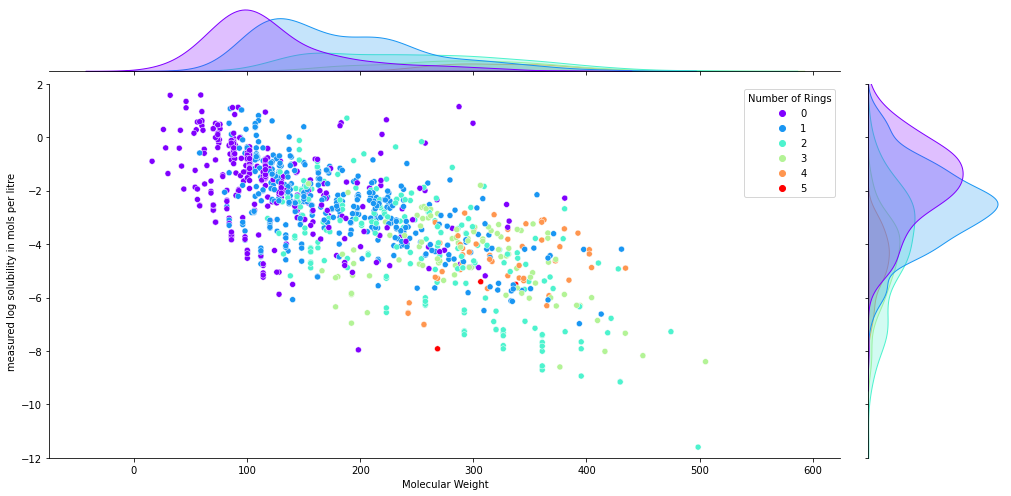

In [31]:

# Here we show the distribution of both the solubility and the molecular weight.
# Both variables grouped by the number of rings in the molecules.
# ==============================================================================
jointplot_mw = sns.jointplot(x='Molecular Weight', y='measured log solubility in mols per litre', 
               hue='Number of Rings', 
               palette='rainbow', height=7,
               data=df)

jointplot_mw.fig.set_figwidth(15)
plt.ylim(-12,2)
plt.show()


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>5. Simple Models</b> </font>
<a name="cleaning"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


<font size='4'>

Keep in mind that all of the models presented here are used with their default parameters. This is of course a naive approach for ML modeling but for the goals already discussed in this notebook it does not represents a major issue.

Future model optimization will be performed in the next notebook if this series. 

</font> 

In [32]:

# Linear Models
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


# SVM Models
# ==============================================================================
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


# KNN Models
# ==============================================================================
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor


# Gaussian Process Models
# ==============================================================================
from sklearn.gaussian_process import GaussianProcessRegressor


# Cross Decomposition Process Models
# ==============================================================================
from sklearn.cross_decomposition import PLSRegression


# Ensemble Models
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor      # Bagging
from sklearn.ensemble import GradientBoostingRegressor  # Boosting



# Datasets


In [33]:

# Here we separate the independent variables for their analysis
# ==============================================================================
X = df.copy(deep=True)
X.drop(columns=['measured log solubility in mols per litre'], inplace=True)
X.head()


,Molecular Weight,Polar Surface Area,Number of Rings,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds
0,201.225,42.24,2,76,11,4
1,152.237,17.07,0,62,0,3
2,84.143,0.00,1,26,5,0
3,326.437,0.00,2,88,12,1
4,272.388,40.46,4,108,6,1


In [34]:

# Define the target variable
# ==============================================================================
y = df['measured log solubility in mols per litre']


In [35]:

# Train-Test split of the dataset
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [36]:
print(X_train)

     Molecular Weight  ...  Number of Conjugated Bonds
236           121.183  ...                           1
5              85.106  ...                           1
351           100.146  ...                           1
688           100.205  ...                           0
731            99.089  ...                           2
..                ...  ...                         ...
835           186.339  ...                           0
192            78.542  ...                           0
629            87.122  ...                           2
559           178.234  ...                           0
684           102.177  ...                           0

[812 rows x 6 columns]


In [37]:

# List to store the models and their names
# ==============================================================================

models = []

models.append(("LinearRegression", LinearRegression()))
models.append(("Ridge", Ridge()))
models.append(("Lasso", Lasso()))
models.append(("ElasticNet", ElasticNet()))
models.append(("LinearSVR", LinearSVR()))
models.append(("SVR", SVR()))
models.append(("KNeighborsRegressor", KNeighborsRegressor()))
models.append(("RadiusNeighborsRegressor", RadiusNeighborsRegressor()))
models.append(("GaussianProcessRegressor", GaussianProcessRegressor()))
models.append(("PLSRegression", PLSRegression()))
models.append(("RandomForestRegressor", RandomForestRegressor()))
models.append(("GradientBoostingRegressor", GradientBoostingRegressor()))


In [38]:

# Define the Mean Absolute Error. Our definition is slighly different due to the
# particular data manipuluation of our features.
# ==============================================================================

def mae(x_test, y_test, y, model):
    y_pred = model.predict(x_test)
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    
    mae = metrics.mean_absolute_error(y_pred, y_test)
    
    return np.round(mae, decimals=4)


In [39]:

# Define the Root Mean Square Error. Our definition is slighly different due to the
# particular data manipuluation of our features.
# ==============================================================================

def rmse(x_test, y_test, y, model):
    y_pred = model.predict(x_test)
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    
    rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
 
    return np.round(rmse, decimals=4)


In [40]:

# List to store the metrics results for all models
# ==============================================================================

names        = []
mae_results  = []
rmse_results = []


In [41]:

# Loop to store all results
# ==============================================================================

for name, model in models:
    
    # Get the model name
    names.append(name)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Store the MAE
    mae_results.append( mae(X_test, y_test, y, model) )
    
    # Store the RMSE
    rmse_results.append( rmse(X_test, y_test, y, model) )
                                                   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [42]:

# Loop to print all of the results
# ==============================================================================

for i in range(len(names)):
    print(names[i], mae_results[i], rmse_results[i])


LinearRegression 0.8551 1.0414
Ridge 0.8551 1.0414
Lasso 0.8785 1.0667
ElasticNet 0.8652 1.0503
LinearSVR 1.0822 1.3171
SVR 0.7831 0.9794
KNeighborsRegressor 0.689 0.8881
RadiusNeighborsRegressor 5.5718 7.0769
GaussianProcessRegressor 1.8987 2.6317
PLSRegression 0.9379 1.1681
RandomForestRegressor 0.5417 0.7184
GradientBoostingRegressor 0.5779 0.7441


<br>
<br>
<br>

# Transforming the Features



In [43]:

# Transformation to fix features
# ==============================================================================

from sklearn.preprocessing import PowerTransformer


In [44]:

# Define the Mean Absolute Error for Transformed Features. 
# Our definition is slighly different due to the particular data manipuluation of our features.
# ==============================================================================

def mae_transformed_features(x_test, y_test, y, model):
    y_pred = model.predict(x_test)
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    
    mae = metrics.mean_absolute_error(y_pred, y_test)
    
    return np.round(mae, decimals=4)


In [45]:

# Define the Root Mean Square Error for Transformed Features. 
# Our definition is slighly different due to the particular data manipuluation of our features.
# ==============================================================================
def rmse_transformed_features(x_test, y_test, y, model):
    y_pred = model.predict(x_test)
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    
    rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    
    return np.round(rmse, decimals=4)


In [46]:

# Define the Feature transformer
# ==============================================================================
power_transformer = PowerTransformer(method='yeo-johnson')


In [47]:

# Define the Feature Dataframe
# ==============================================================================
X_t = df.copy(deep=True)
X_t.drop(columns='measured log solubility in mols per litre', inplace=True)
X_t.head()


,Molecular Weight,Polar Surface Area,Number of Rings,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds
0,201.225,42.24,2,76,11,4
1,152.237,17.07,0,62,0,3
2,84.143,0.00,1,26,5,0
3,326.437,0.00,2,88,12,1
4,272.388,40.46,4,108,6,1


In [48]:

# Transform the Feature Dataframe
# ==============================================================================
X_trans = power_transformer.fit_transform(X_t)


In [49]:

# Train-Test split of the transformed dataset
# ==============================================================================
X_train_t, X_test_t, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=0)


In [50]:

# List to store the models and their names for the transformed features
# ==============================================================================
models_t = []

models_t.append(("LinearRegression", LinearRegression()))
models_t.append(("Ridge", Ridge()))
models_t.append(("Lasso", Lasso()))
models_t.append(("ElasticNet", ElasticNet()))
models_t.append(("LinearSVR", LinearSVR()))
models_t.append(("SVR", SVR()))
models_t.append(("KNeighborsRegressor", KNeighborsRegressor()))
models_t.append(("RadiusNeighborsRegressor", RadiusNeighborsRegressor()))
models_t.append(("GaussianProcessRegressor", GaussianProcessRegressor()))
models_t.append(("PLSRegression", PLSRegression()))
models_t.append(("RandomForestRegressor", RandomForestRegressor()))
models_t.append(("GradientBoostingRegressor", GradientBoostingRegressor()))


In [51]:

# List to store the metrics results for all models with transformed features
# ==============================================================================
mae_results_t  = []
rmse_results_t = []


In [52]:

# Loop to store all results for the transformed features
# ==============================================================================

for name, model in models_t:
    # Fit the model
    model.fit(X_train_t, y_train)
    
    # Store MAE
    mae_results_t.append( mae_transformed_features(X_test_t, y_test, y, model) )
    
    # Store RMSE
    rmse_results_t.append( rmse_transformed_features(X_test_t, y_test, y, model) )
                                                   


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [53]:

# Loop to print all of the results for the models with transformed features
# ==============================================================================

for i in range(len(names)):
    print(names[i], mae_results_t[i], rmse_results_t[i])


LinearRegression 0.7149 0.8676
Ridge 0.7152 0.8679
Lasso 1.3608 1.7262
ElasticNet 1.2352 1.5515
LinearSVR 0.7048 0.8665
SVR 0.577 0.7505
KNeighborsRegressor 0.6113 0.7741
RadiusNeighborsRegressor 0.7283 1.0682
GaussianProcessRegressor 16.1942 61.2316
PLSRegression 0.8382 1.0387
RandomForestRegressor 0.5263 0.7055
GradientBoostingRegressor 0.574 0.7386


<br>
<br>
<br>

# Transforming the Target



In [54]:

# Transformer for the target variable
# ==============================================================================
from sklearn.preprocessing import RobustScaler
robust_transformer = RobustScaler()


In [55]:

# MAE for the transformed Dataset
# ==============================================================================

def mae_transformed_data(x_test, y_test, y, model):
    y_pred = robust_transformer.inverse_transform(model.predict(x_test).reshape(1, -1))
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    y_true = robust_transformer.inverse_transform(y_test).reshape(1, -1)
    
    mae = metrics.mean_absolute_error(y_pred, y_true)
    
    return np.round(mae, decimals=4)


In [56]:

# RMSE for the transformed Dataset
# ==============================================================================

def rmse_transformed_data(x_test, y_test, y, model):
    y_pred = robust_transformer.inverse_transform(model.predict(x_test).reshape(1, -1))
    y_pred = np.nan_to_num(y_pred, nan=np.amin(y))
    y_true = robust_transformer.inverse_transform(y_test).reshape(1, -1)
    
    rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_true))
    
    return np.round(rmse, decimals=4)


In [57]:

# Transformed the target variable
# ==============================================================================
y_t = df['measured log solubility in mols per litre'].values.reshape(-1,1).astype(np.float32)
y_trans = robust_transformer.fit_transform(y_t)


In [58]:

# Train-Test split for the transformed dataset
# ==============================================================================
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_trans, y_trans, test_size=0.2, random_state=0)


In [59]:

# List to store the models and their names for the transformed dataset
# ==============================================================================
models_f = []

models_f.append(("LinearRegression", LinearRegression()))
models_f.append(("Ridge", Ridge()))
models_f.append(("Lasso", Lasso()))
models_f.append(("ElasticNet", ElasticNet()))
models_f.append(("LinearSVR", LinearSVR()))
models_f.append(("SVR", SVR()))
models_f.append(("KNeighborsRegressor", KNeighborsRegressor()))
models_f.append(("RadiusNeighborsRegressor", RadiusNeighborsRegressor()))
models_f.append(("GaussianProcessRegressor", GaussianProcessRegressor()))
models_f.append(("PLSRegression", PLSRegression()))
models_f.append(("RandomForestRegressor", RandomForestRegressor()))
models_f.append(("GradientBoostingRegressor", GradientBoostingRegressor()))


In [60]:

# List to store the metrics results for all models with the transformed dataset
# ==============================================================================

mae_results_f  = []
rmse_results_f = []


In [61]:

# Loop to store all results for the transformed dataset
# ==============================================================================

for name, model in models_f:
    model.fit(X_train_t, y_train_t)
    mae_results_f.append( mae_transformed_data(X_test_t, y_test_t, y_trans, model)  )
    rmse_results_f.append( rmse_transformed_data(X_test_t, y_test_t, y_trans, model) )
                                                   


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:3

In [62]:

# Metrics for the transformed dataset
# ==============================================================================

for i in range(len(names)):
    print(names[i], mae_results_f[i], rmse_results_f[i])


LinearRegression 0.7149 0.8676
Ridge 0.7152 0.8679
Lasso 1.5291 1.9599
ElasticNet 1.4977 1.9215
LinearSVR 0.7052 0.8669
SVR 0.5585 0.7291
KNeighborsRegressor 0.6113 0.7741
RadiusNeighborsRegressor 0.6879 0.8736
GaussianProcessRegressor 16.1884 61.2583
PLSRegression 0.8382 1.0387
RandomForestRegressor 0.5289 0.7079
GradientBoostingRegressor 0.574 0.7386


In [63]:

# Function to compare the 3 strategies
# ==============================================================================

def plot_strategies(x, x_trans, y, y_trans, index):

    
    fig, (ax0, ax1) = plt.subplots(2, 3, sharey='row', figsize=(15, 10))
    fig.suptitle('{} Model'.format(names[index]))
    
    # ==============================================================================
    # ==============================================================================
    
    if np.shape(models[index][1].predict(x)) == (1015,):
        x_vec = np.nan_to_num(models[index][1].predict(x), nan=np.amin(y))
    else:
        x_vec = np.nan_to_num(models[index][1].predict(x).flatten(), nan=np.amin(y))
    
    # ==============================================================================
    # ==============================================================================
    
    x_vec_t = np.nan_to_num(models_t[index][1].predict(x_trans).reshape(-1,1).flatten(), nan=np.amin(y_t))
    
    # ==============================================================================
    # ==============================================================================
    
    if np.shape(models_f[index][1].predict(x_trans)) == (1015,1):
        x_vec_f = np.nan_to_num(robust_transformer.inverse_transform(
            models_f[index][1].predict(x_trans)).flatten(), nan=np.amin(y_t))
    else:
        x_vec_f = np.nan_to_num(robust_transformer.inverse_transform(
            models_f[index][1].predict(x_trans).reshape(-1,1)).flatten(), nan=np.amin(y_t))
        
    # ==============================================================================
    # ==============================================================================
        
    y_vec_f = robust_transformer.inverse_transform(y_trans).flatten()
    
    
    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax0[0].set_title('No Feature or Target Transformation \n $MAE$=%.2f, RMSE=%.2f'
                     %(mae_results[index], rmse_results[index]))

    sns.scatterplot(x=x_vec, y=y, ax=ax0[0])
    ax0[0].plot([-20, 3], [-20,3], '--k')
    ax0[0].set_ylabel('True target')
    ax0[0].set_xlabel('Predicted target')
    ax0[0].ticklabel_format(axis="both")
    ax0[0].set_ylim([-12.5, 2.5])

    

    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax0[1].set_title('Feature Transformation with No Target Transformation \n $MAE$=%.2f, RMSE=%.2f'
                     %(mae_results_t[index], rmse_results_t[index]))

    sns.scatterplot(x=x_vec_t, y=y, ax=ax0[1])
    ax0[1].plot([-20, 3], [-20,3], '--k')
    ax0[1].set_ylabel('True target')
    ax0[1].set_xlabel('Predicted target')
    ax0[1].ticklabel_format(axis="both")


    
    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax0[2].set_title('Feature and Target Transformation \n $MAE$=%.2f, RMSE=%.2f'
                     %(mae_results_f[index], rmse_results_f[index]))
    sns.scatterplot(x=x_vec_f, y=y_vec_f, ax=ax0[2])
    ax0[2].plot([-20, 3], [-20,3], '--k')
    ax0[2].set_ylabel('True target')
    ax0[2].set_xlabel('Predicted target')
    ax0[2].ticklabel_format(axis="both")


    
    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax1[0].set_title('Abs Error Histogram')
    sns.histplot(np.abs(x_vec-y), ax=ax1[0], bins=10, stat='probability')
    ax1[0].set_ylabel('Fraction')
    ax1[0].set_xlabel('Absolute Error')

    

    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax1[1].set_title('Abs Error Histogram')
    sns.histplot(np.abs(x_vec_t - y), ax=ax1[1], bins=10, stat='probability')
    ax1[1].set_ylabel('Fraction')
    ax1[1].set_xlabel('Absolute Error')



    # Here we pick the feautures after data cleaning
    # ==============================================================================
    ax1[2].set_title('Abs Error Histogram')
    sns.histplot(np.abs(x_vec_f - y_vec_f), ax=ax1[2], bins=10, stat='probability')
    ax1[2].set_ylabel('Fraction')
    ax1[2].set_xlabel('Absolute Error')


    
    plt.show()

    


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn

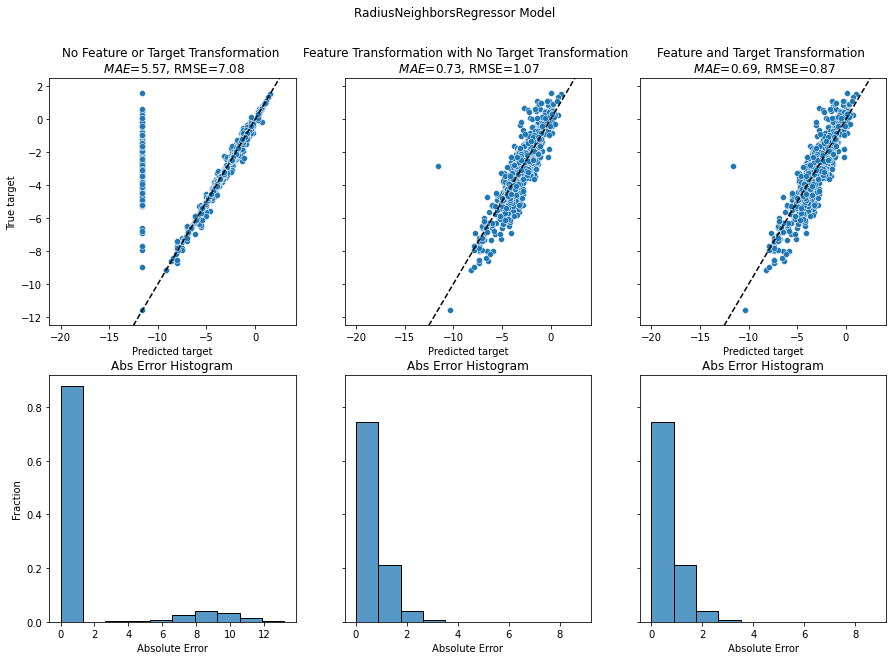

In [64]:

# Here you can choose the index of the model you wamt to visualize
# ==============================================================================
plot_strategies(X, X_trans, y, y_trans, 7)


In [65]:

# Table to compare all of the metrics
# ==============================================================================

table_results = pd.DataFrame(list(zip(mae_results, mae_results_t, mae_results_f, rmse_results, 
                                      rmse_results_t, rmse_results_f)), 
                  index=names, 
                  columns =['MAE','MAE Tranformed Features','MAE Transformed Data', 
                            'RMSE','RMSE Tranformed Features','RMSE Tranformed Data'])

table_results.style.highlight_min(color = 'lightgreen',  
                       axis = 0).highlight_max(color = 'LightCoral',  
                       axis = 0)


,MAE,MAE Tranformed Features,MAE Transformed Data,RMSE,RMSE Tranformed Features,RMSE Tranformed Data
LinearRegression,0.855,0.715,0.715,1.041,0.868,0.868
Ridge,0.855,0.715,0.715,1.041,0.868,0.868
Lasso,0.878,1.361,1.529,1.067,1.726,1.960
ElasticNet,0.865,1.235,1.498,1.050,1.552,1.921
LinearSVR,1.082,0.705,0.705,1.317,0.867,0.867
SVR,0.783,0.577,0.558,0.979,0.750,0.729
KNeighborsRegressor,0.689,0.611,0.611,0.888,0.774,0.774
RadiusNeighborsRegressor,5.572,0.728,0.688,7.077,1.068,0.874
GaussianProcessRegressor,1.899,16.194,16.188,2.632,61.232,61.258
PLSRegression,0.938,0.838,0.838,1.168,1.039,1.039


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>6. Cross Validation</b> </font>
<a name="features"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>



# Repeated K-Fold Validation


In [66]:

# Import the repeated k-fold object
# ==============================================================================
from sklearn.model_selection import RepeatedKFold


In [67]:

# Lists to store all of the results
# ==============================================================================
mae_results_cv  = []
rmse_results_cv = []


# Initialize the k-fold validator
# ==============================================================================
cv = RepeatedKFold(n_splits=5, n_repeats=6)


In [68]:

# Custome MAE function to evaluate the repeated k-fold validation
# ==============================================================================

def mae_cv(x_trans, y_trans, cross_val, model):
    mae_vector = []
    
    for train_index, test_index in cross_val.split(X_trans, y_trans):
    
        X_train_cv, X_test_cv = x_trans[train_index], x_trans[test_index]
        y_train_cv, y_test_cv = y_trans[train_index], y_trans[test_index]

        # fit model
        model.fit(X_train_cv, y_train_cv)

        # make predictions
        y_pred = robust_transformer.inverse_transform(model.predict(X_test_cv).reshape(1, -1))
        y_pred = np.nan_to_num(y_pred, nan=np.amin(y_trans))
        y_true = robust_transformer.inverse_transform(y_test_cv).reshape(1, -1)
        
        # store
        mae = metrics.mean_absolute_error(y_pred, y_true)
        mae_vector.append(np.round(mae, decimals=4))
        
    
    return mae_vector


In [69]:

# Custome RMSE function to evaluate the repeated k-fold validation
# ==============================================================================

def rmse_cv(x_trans, y_trans, cross_val, model):
    rmse_vector = []
    
    for train_index, test_index in cross_val.split(X_trans, y_trans):
    
        X_train_cv, X_test_cv = x_trans[train_index], x_trans[test_index]
        y_train_cv, y_test_cv = y_trans[train_index], y_trans[test_index]

        # fit model
        model.fit(X_train_cv, y_train_cv)

        # make predictions
        y_pred = robust_transformer.inverse_transform(model.predict(X_test_cv).reshape(1, -1))
        y_pred = np.nan_to_num(y_pred, nan=np.amin(y_trans))
        y_true = robust_transformer.inverse_transform(y_test_cv).reshape(1, -1)
        
        # store
        rmse = np.sqrt(metrics.mean_absolute_error(y_pred, y_true))
        rmse_vector.append(np.round(rmse, decimals=4))
        
    
    return rmse_vector


In [70]:

# Store models and names
# ==============================================================================

models_cv = []

models_cv.append(("LinearRegression", LinearRegression()))
models_cv.append(("Ridge", Ridge()))
models_cv.append(("Lasso", Lasso()))
models_cv.append(("ElasticNet", ElasticNet()))
models_cv.append(("LinearSVR", LinearSVR()))
models_cv.append(("SVR", SVR()))
models_cv.append(("KNeighborsRegressor", KNeighborsRegressor()))
models_cv.append(("RadiusNeighborsRegressor", RadiusNeighborsRegressor()))
models_cv.append(("GaussianProcessRegressor", GaussianProcessRegressor()))
models_cv.append(("PLSRegression", PLSRegression()))
models_cv.append(("RandomForestRegressor", RandomForestRegressor()))
models_cv.append(("GradientBoostingRegressor", GradientBoostingRegressor()))


In [71]:

# Store the k-fold results
# ==============================================================================
mae_results_cv  = []
rmse_results_cv = []


In [72]:

# Loop to evaluate all models
# ==============================================================================

for name, model in models_cv:
    # MAE
    mae_results_cv.append( mae_cv(X_trans, y_trans, cv, model)  )
    
    # RMSE
    rmse_results_cv.append( rmse_cv(X_trans, y_trans, cv, model) )
    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: Data

In [73]:

# Vectors to store all of the mean and standar deviation of the metrics
# ==============================================================================
mae_mean_vector = [np.round(np.mean(case), decimals=3) for case in mae_results_cv]
mae_std_vector  = [np.round(np.std(case), decimals=3) for case in mae_results_cv]


# ==============================================================================
# ==============================================================================

rmse_mean_vector = [np.round(np.mean(case), decimals=3) for case in rmse_results_cv]
rmse_std_vector  = [np.round(np.std(case), decimals=3) for case in rmse_results_cv]




In [74]:

# Table for the K-fold results
# ==============================================================================
cv_results = pd.DataFrame(list(zip(mae_mean_vector, mae_std_vector, 
                                   rmse_mean_vector, rmse_std_vector)), 
                  index=names, 
                  columns =['Mean MAE','MAE Standar Deviation', 
                            'Mean RMSE','RMSE Standar Deviation'])

cv_results.round(4).style.highlight_min(color = 'lightgreen',  
                       axis = 0).highlight_max(color = 'LightCoral',  
                       axis = 0)


,Mean MAE,MAE Standar Deviation,Mean RMSE,RMSE Standar Deviation
LinearRegression,0.695,0.034,0.833,0.021
Ridge,0.694,0.037,0.832,0.020
Lasso,1.555,0.068,1.247,0.024
ElasticNet,1.526,0.079,1.235,0.039
LinearSVR,0.692,0.033,0.833,0.022
SVR,0.546,0.030,0.742,0.019
KNeighborsRegressor,0.611,0.043,0.783,0.028
RadiusNeighborsRegressor,0.687,0.038,0.828,0.016
GaussianProcessRegressor,25.047,9.090,5.137,1.200
PLSRegression,0.821,0.053,0.906,0.022


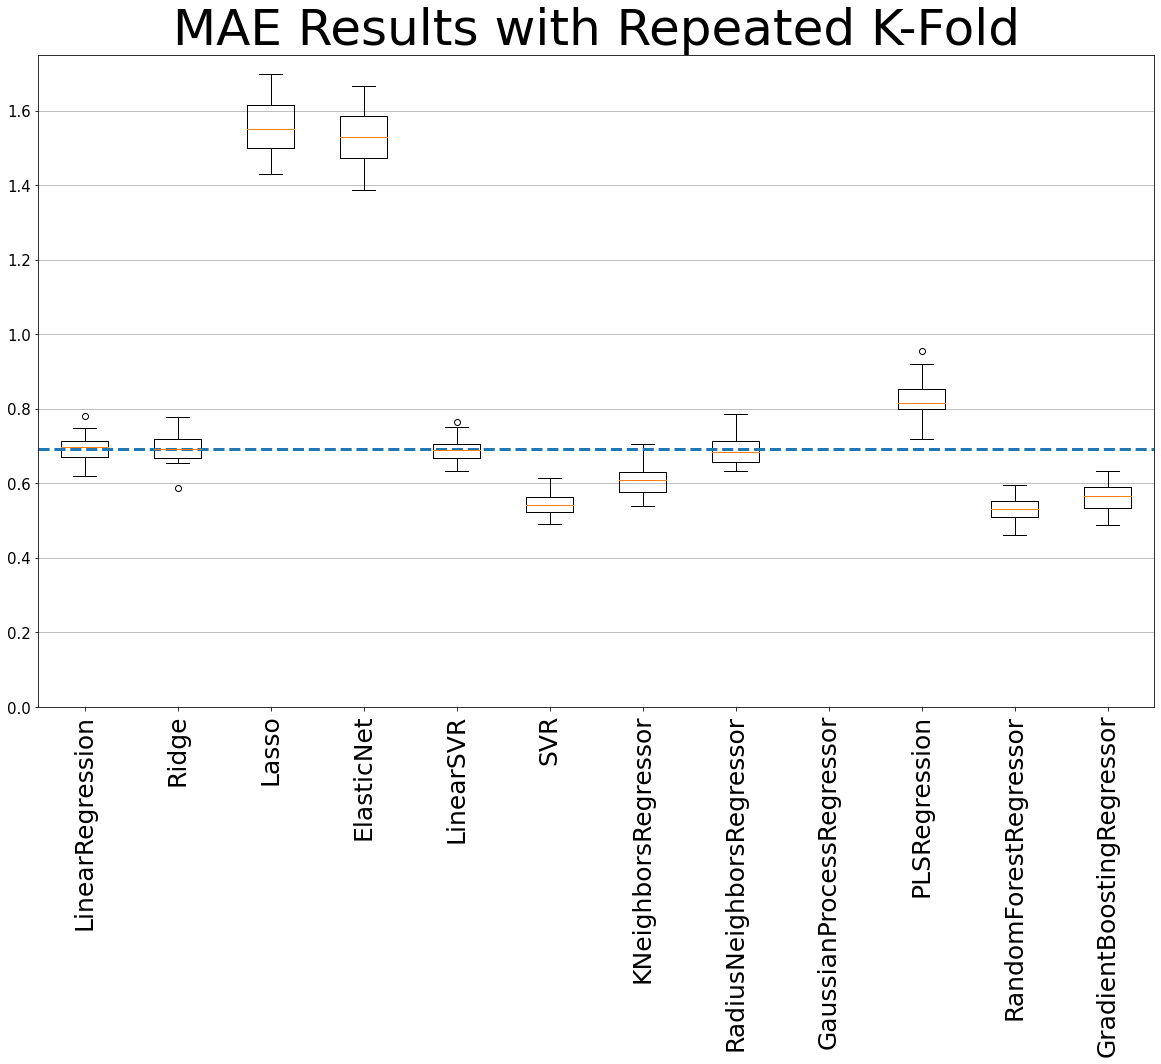

In [75]:

# Box plot to summarize the performance of all models for MAE
# ==============================================================================

plt.figure(figsize=(20,12))
plt.title('MAE Results with Repeated K-Fold', fontsize=50)
plt.boxplot(mae_results_cv, labels=names)
plt.ylim(0, 1.75)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=15)


plt.axhline(y=0.6932, ls='--', lw=3)
plt.grid(axis='y')
plt.show()


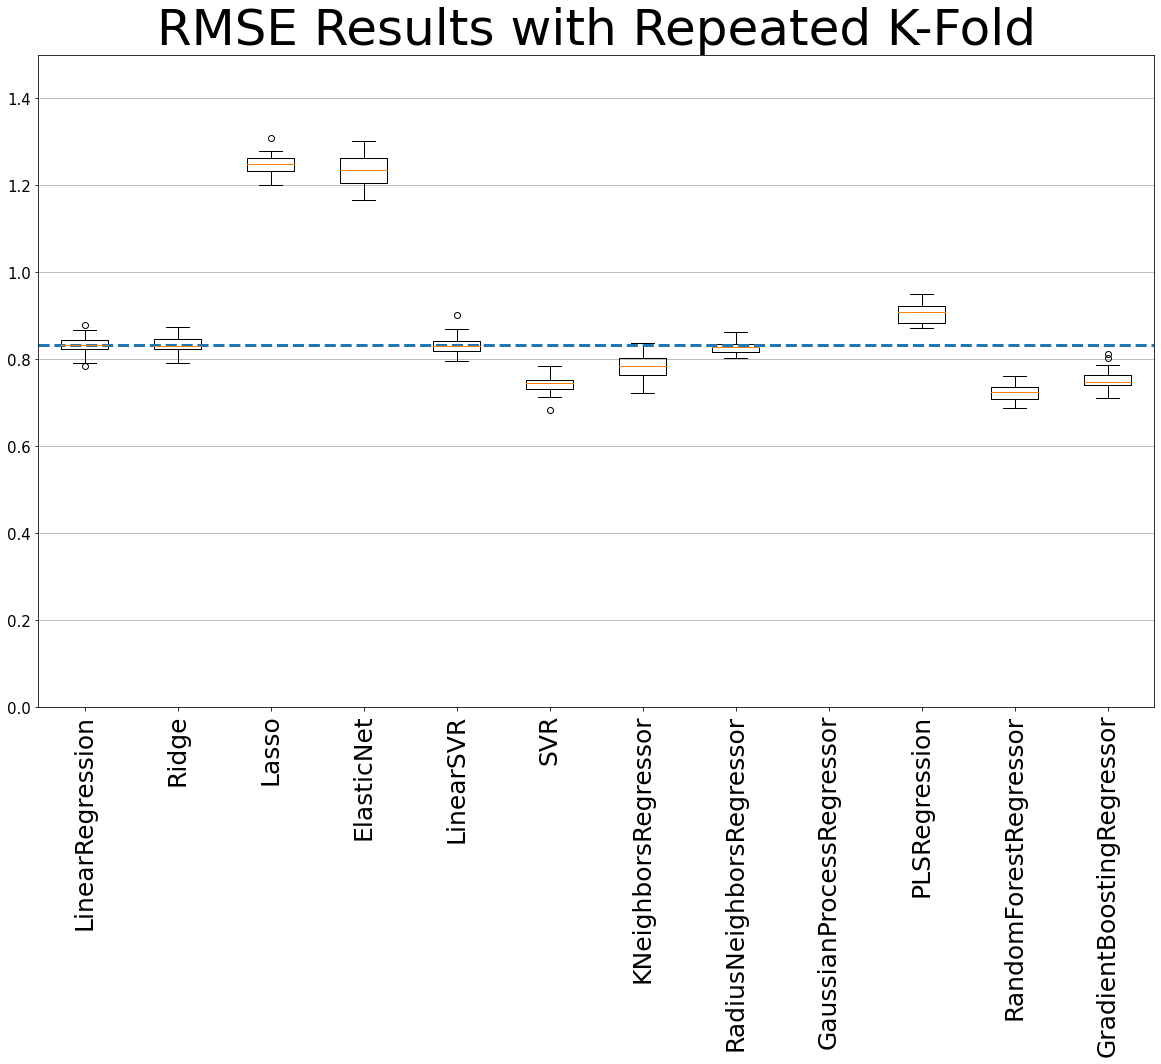

In [76]:

# Box plot to summarize the performance of all models for MAE
# ==============================================================================

plt.figure(figsize=(20,12))
plt.title('RMSE Results with Repeated K-Fold', fontsize=50)
plt.boxplot(rmse_results_cv, labels=names)
plt.ylim(0, 1.5)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=15)


plt.axhline(y=0.8326, ls='--', lw=3)
plt.grid(axis='y')
plt.show()


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>7. Results & Discussion</b> </font>
<a name="results"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


<font size='4'>

As seen in the final benchmark of all models, the Random Forest Regressor performs consistenly well across all strategies giving surprisingly good metrics for a model with no hyper-parameter optimization. 

Interesting to note ho the performance for the Gaussian Regressor suffers after transforming the features. However, perhaps further optimization of this model will fix this problem.

In general, most of the models without optimization do not perform much better than the Linear Regression. As you might already expect after optimizing all of the models we will discar those that do not give a valuable advantge over the reference simple Lienar Regression model.

</font> 




<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>8. Perspectives</b> </font>
<a name="perspectives"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>



    i.   Create pipelines to accelerate modeling benchmarking. 
    ii.  Investigate the drop in performance for the Gaussian Process.  
    iii. Explore the impact of adding more molecular descriptors in all models. 
    iv.  Compare more traditional models, Tree-based models and NN in the benchmark.

<br>
<br>
<br>
<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>9. References.</b> </font>
<a name="references"></a>

[[ Back to Top ]](#Table-of-contents)

[1] <a href=https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0>Transforming Skewed Data for Machine Learning</a>

[2] <a href=https://machinelearningmastery.com/power-transforms-with-scikit-learn/>How to Use Power Transforms for Machine Learning</a>

[3] <a href=https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02>Scale, Standardize, or Normalize with Scikit-Learn</a>

[4] <a href=https://www.mygreatlearning.com/blog/linear-regression-in-machine-learning/>Linear Regression in Machine Learning Definition, Advantage & uses</a>

[5] <a href=https://blog.dataiku.com/tree-based-models-how-they-work-in-plain-english>Tree-Based Models: How They Work (In Plain English!)</a>

[6] <a href=https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4>Choosing the Right Metric for Evaluating Machine Learning Models — Part 1</a>